### Model Correlations
This code computes and plots the correlation of three satellite brightness models for Starlink v1.5 satellites. The first is our model with lab measured BRDF data. The second is a diffuse sphere model. The third is our model with BRDFs inferred from on-orbit brightness measurements.

In [1]:
# Imports
import pandas as pd
import lumos.calculator
import lumos.conversions
import numpy as np
import astropy.time
import astropy.coordinates
import scipy.stats
import matplotlib.pyplot as plt
import satellite_models.diffuse_sphere as diffuse_sphere
import satellite_models.starlink_v1p5 as starlink_v1p5

In [2]:
data = pd.read_csv("../data/pomenis_observations.csv", comment = "#")

satellite_heights = 1000 * (data['satellite_height'].to_numpy())
observation_times = data['observation_time'].to_numpy()
satellite_altitudes = data['satellite_altitude'].to_numpy()
satellite_azimuths = data['satellite_azimuth'].to_numpy()
measured_magnitudes = data['ab_magnitude'].to_numpy()

mount_lemmon = astropy.coordinates.EarthLocation(lat = 32.4434, lon = -110.7881)

In [3]:
intensities_diffuse_sphere = np.zeros_like(measured_magnitudes)
intensities_lab_brdfs = np.zeros_like(measured_magnitudes)
intensities_inferred_brdfs = np.zeros_like(measured_magnitudes)

for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_altitudes, satellite_azimuths, satellite_heights, observation_times)):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)

    intensities_diffuse_sphere[i] = \
        diffuse_sphere.get_intensity(0.65, sat_h, sat_alt, sat_az, sun_alt, sun_az)
    
    intensities_lab_brdfs[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = False)
    
    intensities_inferred_brdfs[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_INFER_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = False)

magnitudes_diffuse_sphere = lumos.conversions.intensity_to_ab_mag(intensities_diffuse_sphere)
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_lab_brdfs)
magnitudes_inferred_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs)

Our Model (Lab BRDFs), R = 0.69
Our Model (Best-Fit BRDFs), R = 0.68
Diffuse Sphere, R = 0.47


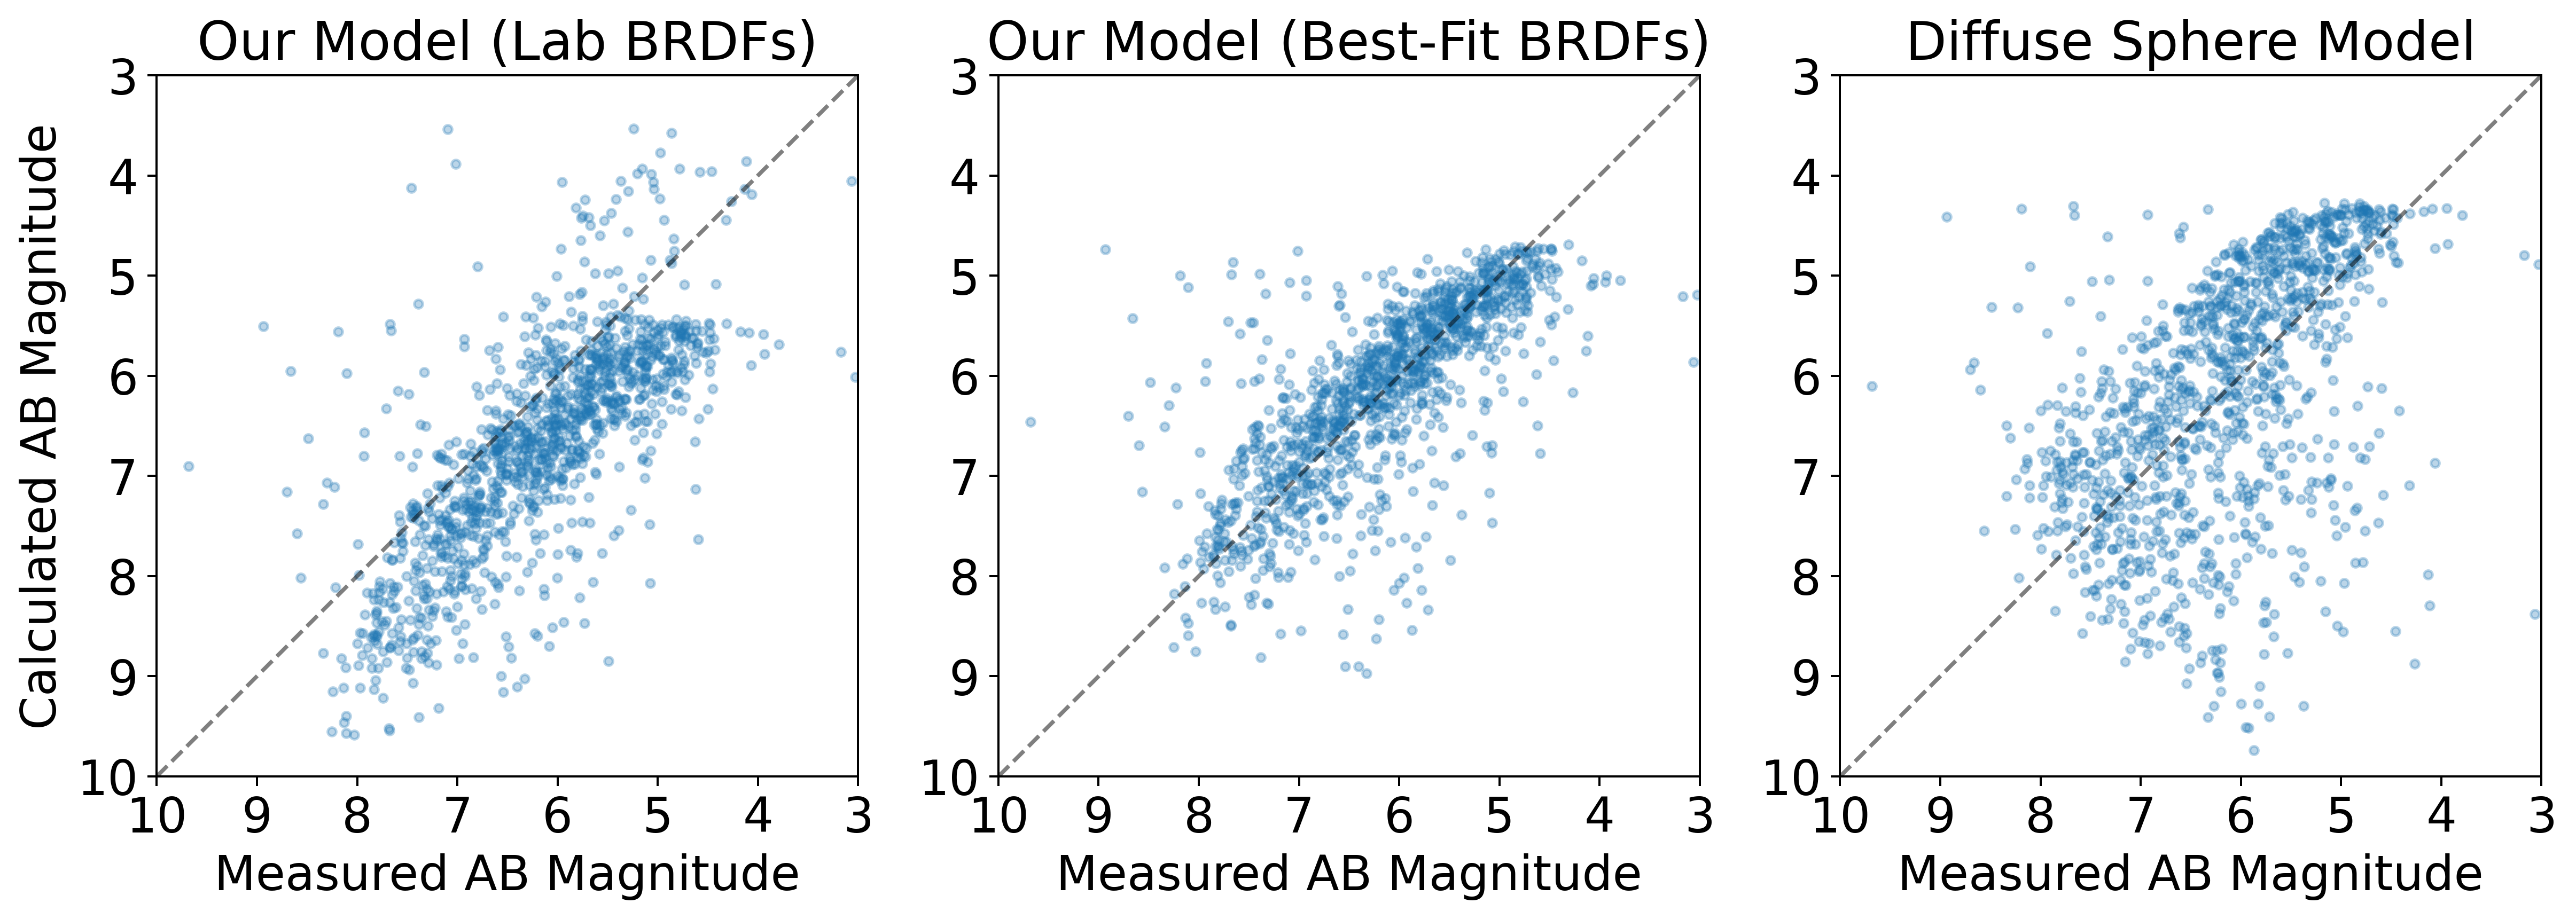

In [4]:
fig, axs = plt.subplots(1, 3, figsize = (16, 5), dpi = 360, sharex = True)
ax1, ax2, ax3 = axs

for ax in axs:
    ax.set_xlim((3, 10))
    ax.set_ylim((3, 10))
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.set_xlabel("Measured AB Magnitude", fontsize = 18)
    ax.set_ylabel("Calculated AB Magnitude", fontsize = 18)
    ax.plot([10, 2], [10, 2], '--k', alpha = 0.5)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xticks([10, 9, 8, 7, 6, 5, 4, 3])
    ax.set_yticks([10, 9, 8, 7, 6, 5, 4, 3])

ax2.set_ylabel("")
ax3.set_ylabel("")

ax1.scatter(measured_magnitudes,
            magnitudes_lab_brdfs,
            color = '#1f77b4',
            alpha = 0.3,
            s = 10)

corr, _ = scipy.stats.pearsonr(magnitudes_lab_brdfs, measured_magnitudes)
print(f"Our Model (Lab BRDFs), R = {corr:0.2f}")
ax1.set_title("Our Model (Lab BRDFs)", fontsize = 20)

ax2.scatter(measured_magnitudes,
            magnitudes_inferred_brdfs,
            color = '#1f77b4',
            alpha = 0.3,
            s = 10)
corr, _ = scipy.stats.pearsonr(magnitudes_inferred_brdfs, measured_magnitudes)
print(f"Our Model (Best-Fit BRDFs), R = {corr:0.2f}")
ax2.set_title("Our Model (Best-Fit BRDFs)", fontsize = 20)

ax3.scatter(measured_magnitudes,
            magnitudes_diffuse_sphere,
            color = '#1f77b4',
            alpha = 0.3,
            s = 10)
corr, _ = scipy.stats.pearsonr(magnitudes_diffuse_sphere, measured_magnitudes)
print(f"Diffuse Sphere, R = {corr:0.2f}")
ax3.set_title("Diffuse Sphere Model", fontsize = 20)

plt.show()